In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

init_position = np.array([np.pi/2, 0])
# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.01,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.01  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

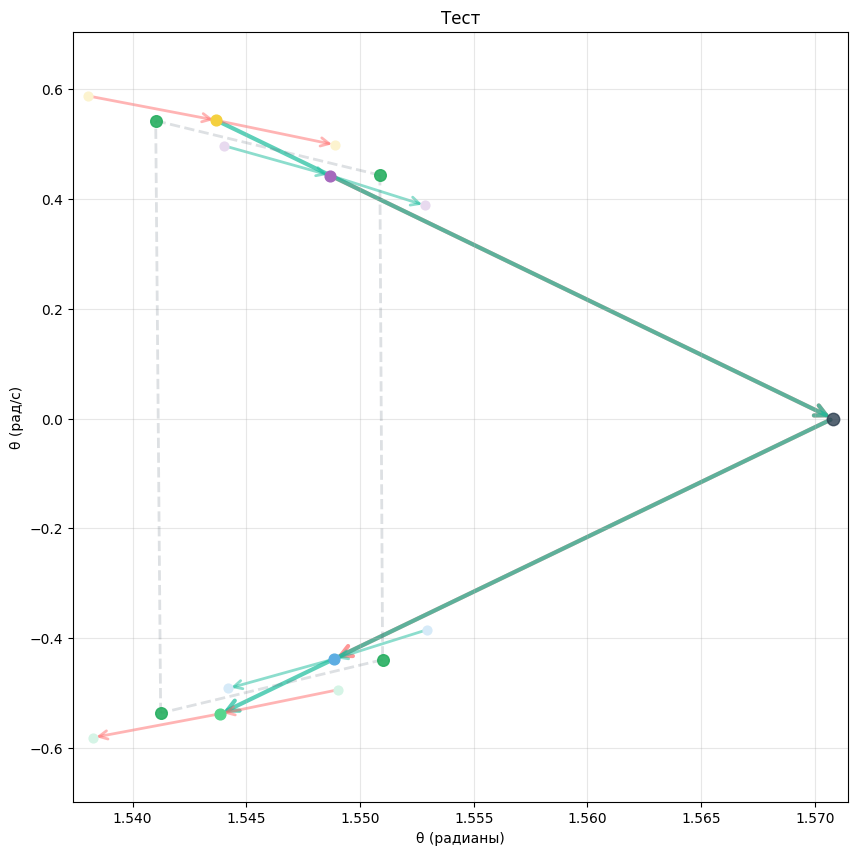

In [5]:
cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)

tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")

C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4440572074557163
            Iterations: 11
            Function evaluations: 155
            Gradient evaluations: 11

--- Результаты Оптимизации ---
Значение функции потерь: -1.444057
Оптимальные dt для детей: [0.0001   0.005835 0.004788 0.0001  ]
Оптимальные dt для внуков: [0.0001   0.005516 0.000194 0.0001   0.0001   0.000307 0.006799 0.0001  ]
Расстояния в итоговых парах: [0.053898 0.02533  0.02527  0.054062]
Итоговая площадь: 0.0
Сумма модулей dt: 0.024038


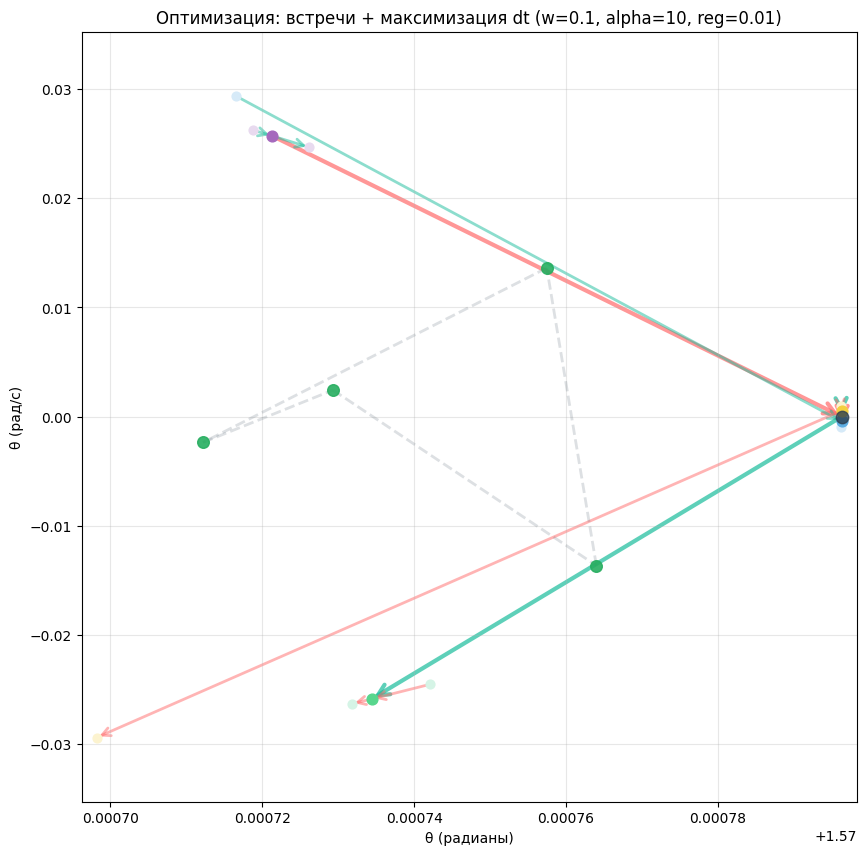

In [ ]:
evaluator = TreeEvaluator(tree)

def objective_dynamic(dt_all, w=0.1, alpha=10):
    """Новая целевая функция, использующая динамическую метрику."""
    return evaluator.dynamic_loss(dt_all, w=w, alpha=alpha, reg_lambda=0) # reg_lambda=0 для базового случая

dt = 0.01
# Начальное приближение
dt_children = np.ones(4) * dt
dt_grandchildren = np.ones(8) * dt * 0.05
init_guess = np.hstack((dt_children, dt_grandchildren))

# Границы для переменных
bounds = [(0.0001, 0.5)] * 12 

# Запускаем оптимизацию
result = minimize(
    objective_dynamic, 
    init_guess, 
    method='SLSQP',
    bounds=bounds, 
    options={'maxiter': 1000, 'disp': True, 'eps': 1e-6}
)

# Обновляем дерево с оптимальными параметрами для визуализации
evaluator._build_if_needed(result.x)

print("\n--- Результаты Оптимизации ---")
print(f"Значение функции потерь: {result.fun:.6f}")
print("Оптимальные dt для детей:", np.round(result.x[:4], 6))
print("Оптимальные dt для внуков:", np.round(result.x[4:], 6))
print("Расстояния в итоговых парах:", np.round(evaluator.pair_distances(result.x), 6))
print("Итоговая площадь:", np.round(evaluator.area(result.x), 6))

visualize_spore_tree(tree, title="Оптимизация с динамической метрикой (w=0.1, alpha=10)")
